<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

# Homework 2: Prediction of DESNT-status from RNA-seq Prostate Adenocarcinoma Data

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## Prostate Adenocarcinoma: A Clinical Challenge

Prostate adenocarcinoma is one of the most common cancers in men worldwide. While many prostate cancers are indolent and slow-growing, a significant proportion progress to more aggressive disease, leading to metastasis and mortality. One of the central challenges in prostate cancer management is distinguishing between **low-risk, indolent tumors** and those that are likely to become **clinically significant and life-threatening**.

Traditional clinical indicators (like PSA levels, Gleason score, and tumor stage) are valuable but often **insufficient** to capture the underlying biological heterogeneity of the disease. More precise molecular tools are needed to improve risk stratification and guide personalized treatment.

## What is DESNT?

**DESNT** (pronounced "descent") is a **molecular subtype** of prostate cancer identified through gene expression profiling. It was first described through unsupervised clustering of large-scale transcriptomic data. Tumors classified as DESNT exhibit a distinct gene expression signature associated with:

- **Poor prognosis**
- **Early biochemical recurrence**
- **More aggressive clinical behavior**

Unlike other prostate cancer subtypes, DESNT is consistently linked to **worse clinical outcomes**, making it a potential marker for identifying high-risk patients.

## Why Predict DESNT?

Being able to predict whether a prostate tumor is DESNT or not has major clinical implications:

- It could **support early intervention** for patients likely to experience aggressive disease.
- It may help **avoid overtreatment** in non-DESNT cases by identifying those with lower-risk tumors.
- It could serve as a foundation for **biomarker discovery** and **treatment targeting**, as we continue to understand what biologically drives the DESNT phenotype.

In this task, we will use RNA-seq gene expression data from prostate cancer patients to **train a machine learning model that predicts DESNT status**. This mirrors real-world translational research efforts that aim to bring molecular signatures from the lab into clinical use.

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## DESNT Classification of Prostate Cancers  
  
The DESNT classification scheme for prostate cancer is first proposed in this paper: https://www.eu-focus.europeanurology.com/article/S2405-4569(17)30025-1/fulltext.  
  
You do not need to read the paper, but it can motivate the problem that we are trying to address if you are interested.  
  
The original DESNT paper split prostate cancers from different patients into 10 subtypes. 8 of these were representative of "indolent" cancer, whilst 2 were indicative of aggressive cancer with worse survival outcomes. To simplify things for this project, we willl group all 8 "indolent" subtypes as "DESNT-negative", and the 2 aggressive subtypes as "DESNT-positive".  
  
The aim of the task is to use **random forest classifiers** to predict the DESNT subtype from RNA-seq data, again taken from the TCGA Pan Cancer Atlas study. 

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

By the end of this notebook, you should be able to: 
1) Build a random forest classifier to identify DESNT status from RNA sequencing data of prostate cancers
2) Evaluate that classifier and comment on how well it performs 
3) Identify a smaller biomarker panel that is indicative of DESNT-positive status in prostate cancers  
  
These tasks were discussed in depth in the `model_evaluation.ipynb` and `biomarker_discovery.ipynb` notebooks. If you get stuck on any of the tasks in this notebook, then refer back to those notebooks for help

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

We will get you started by importing all of the modules that you should need to use  
  

In [1]:
# importing numpy, pandas, code for train_test_splitting, RandomForestClassifier and DecisionTreeClassifier

import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # importing a decision tree model as well as the random forest to test

In [2]:
# importing matplotlib.pyplot for visualising results 

import matplotlib.pyplot as plt 

# this line makes it so that our matplotlib plots are more visually appealing. It is based on the R ggplot library
plt.style.use("ggplot")

In [3]:
# importing functions from scipy for model evaluation: we will explain these later

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

In [4]:
# this is code that installs and imports the SHAP library, so we can use it for biomarker discovery 
src_dir = "../../../src"
import sys
sys.path.append(src_dir)
from install_if_missing import install_if_missing
install_if_missing("shap", verbose=True)

import shap
np.bool = bool

/Users/griffinfarrow/.pyenv/versions/3.9.21/envs/precision-course-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'shap' is already installed.


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 1) Load in the prostate cancer dataset and perform train-test splitting  
  
The dataset is called `pca_dataset_scaled.csv` and should be found in the `dataset` folder in this directory.

In [5]:
# use pandas to read in the dataset

df = pd.read_csv("dataset/pca_dataset_scaled.csv")

In [6]:
df

,SAMPLE_ID,DESNT_Status,AANAT,ABCC11,ABCC6P1,ABHD12B,ABO,ACRV1,ACTBL2,ADAD2,...,ZIM2,ZNF157,ZNF215,ZNF366,ZNF488,ZNF492,ZNF727,ZNF835,ZP1,ZSCAN1
0,TCGA-2A-A8VL-01,Negative,0.000000,0.119146,0.561262,0.329162,0.661124,0.088117,0.000000,0.214586,...,0.000000,0.309641,0.619815,0.523778,0.392332,0.445726,0.553848,0.550153,0.565760,0.782007
1,TCGA-2A-A8VO-01,Positive,0.000000,0.417178,0.365266,0.000000,0.175122,0.638438,0.198816,0.331250,...,0.000000,0.222869,0.171595,0.645184,0.115639,0.000000,0.104470,0.379356,0.543410,0.663852
2,TCGA-2A-A8VT-01,Negative,0.214568,0.251113,0.615095,0.145549,1.000000,0.440768,0.122140,0.331006,...,0.146206,0.325093,0.480499,0.616373,0.550135,0.495654,0.261089,0.887860,0.169667,0.645102
3,TCGA-2A-A8VV-01,Positive,0.000000,0.282514,0.000000,0.000000,0.214199,0.589013,0.000000,0.284799,...,0.354699,0.000000,0.288490,0.523979,0.150534,0.397765,0.248044,0.717047,0.561597,0.757738
4,TCGA-2A-A8VX-01,Positive,0.477714,0.544155,0.343232,0.000000,0.147063,0.320358,0.000000,0.187497,...,0.000000,0.000000,0.128452,0.000000,0.000000,0.000000,0.350775,0.374743,0.774383,0.759774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,SYNTHETIC,Positive,0.017938,0.531199,0.691047,0.000000,0.359685,0.278470,0.015860,0.272518,...,0.227386,0.339934,0.613727,0.724173,0.456254,0.386352,0.476157,0.809339,0.006612,0.857818
652,SYNTHETIC,Positive,0.210230,0.343624,0.127809,0.006255,0.638350,0.236185,0.222388,0.186284,...,0.000000,0.140033,0.801294,0.491009,0.175534,0.087391,0.579707,0.179779,0.541139,0.570487
653,SYNTHETIC,Positive,0.259498,0.340864,0.362246,0.000000,0.346019,0.509422,0.029224,0.274561,...,0.152533,0.312613,0.148152,0.547049,0.102915,0.000000,0.015356,0.055762,0.658352,0.097580
654,SYNTHETIC,Positive,0.000000,0.293127,0.070218,0.102908,0.076201,0.473529,0.000000,0.000000,...,0.035284,0.000000,0.026204,0.464408,0.155558,0.106331,0.045377,0.152847,0.583401,0.122899


In [7]:
# make sure that X only contains gene information
X = df.drop(["DESNT_Status", "SAMPLE_ID"], axis = 1)

# make sure that y contains our DESNT status
y = df["DESNT_Status"]

In [8]:
# you may want to check that X and y look as expected
X.head()

,AANAT,ABCC11,ABCC6P1,ABHD12B,ABO,ACRV1,ACTBL2,ADAD2,ADAM2,ADAM21,...,ZIM2,ZNF157,ZNF215,ZNF366,ZNF488,ZNF492,ZNF727,ZNF835,ZP1,ZSCAN1
0,0.000000,0.119146,0.561262,0.329162,0.661124,0.088117,0.000000,0.214586,0.629245,0.642674,...,0.000000,0.309641,0.619815,0.523778,0.392332,0.445726,0.553848,0.550153,0.565760,0.782007
1,0.000000,0.417178,0.365266,0.000000,0.175122,0.638438,0.198816,0.331250,0.516595,0.000000,...,0.000000,0.222869,0.171595,0.645184,0.115639,0.000000,0.104470,0.379356,0.543410,0.663852
2,0.214568,0.251113,0.615095,0.145549,1.000000,0.440768,0.122140,0.331006,0.705457,0.444222,...,0.146206,0.325093,0.480499,0.616373,0.550135,0.495654,0.261089,0.887860,0.169667,0.645102
3,0.000000,0.282514,0.000000,0.000000,0.214199,0.589013,0.000000,0.284799,0.596686,0.899578,...,0.354699,0.000000,0.288490,0.523979,0.150534,0.397765,0.248044,0.717047,0.561597,0.757738
4,0.477714,0.544155,0.343232,0.000000,0.147063,0.320358,0.000000,0.187497,0.056082,0.214595,...,0.000000,0.000000,0.128452,0.000000,0.000000,0.000000,0.350775,0.374743,0.774383,0.759774


In [9]:
y

0      Negative
1      Positive
2      Negative
3      Positive
4      Positive
         ...   
651    Positive
652    Positive
653    Positive
654    Positive
655    Positive
Name: DESNT_Status, Length: 656, dtype: object

In [10]:
# use train_test_split to do train-test splitting 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 2) Build and train a random forest classifier 
  
Use as hyperparameters: 
* random_state = 42
* n_estimators = 100
* max_depth = 10

In [11]:
# build your model here

model = RandomForestClassifier(random_state = 42,
                                n_estimators = 100, 
                                max_depth = 10)

In [12]:
# train your model here

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 3) Evaluate your model  
  
Using your trained model from the previous task, evaluate the model. You might want to consider: 
* the accuracy of the model
* the f1-score of the model
* the reporter operating characteristic of the model 
* the area under the reporter operating characteristic curve

In [13]:
y_pred_rf = model.predict(X_test)
y_proba_rf = model.predict_proba(X_test)[:,1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, pos_label = "Positive")
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, y_proba_rf, pos_label = "Positive")

In [14]:
print("Accuracy = ", accuracy_rf)
print("F1 = ", f1_rf)
print("ROC-AUC RF = ", roc_auc_rf)


Accuracy =  0.9015151515151515
F1 =  0.8925619834710744
ROC-AUC RF =  0.9781750638495472


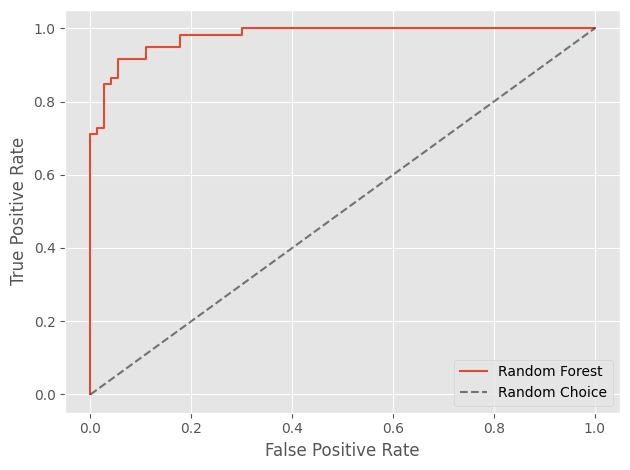

In [15]:
fig, ax = plt.subplots()

ax.plot(fpr_rf, tpr_rf, label = "Random Forest")
ax.plot([0, 1], [0, 1], color = 'k', linestyle = '--', alpha = 0.5, label = "Random Choice")

ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

fig.tight_layout()

plt.show()

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

What can you conclude about your model at this point?
1) What is its accuracy? What does this mean for how your model is classifying samples?
2) What is its f1-score? What does this mean about how your model is balanced sensitivity and positive predictive value?
3) What does the ROC curve look like?
  
Is the random forest model that you have built a good model?  
  
Write some of your thoughts in the next cell

* 
* 
*

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 4) Use SHAP to identify what the most important features are  
  
Now, use the shap module to identify the most important features for your model.  
  
We recommend that you look back at the `biomarker_discovery.ipynb` notebook for how you might do this

In [16]:
# use shap to produce shap scores for every feature
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[0]
abs_shap_values = np.abs(shap_values)
mean_abs_shap_values = np.mean(abs_shap_values, axis = (0,))

In [17]:
shap_df = pd.DataFrame(
    data = sorted(
        dict(zip(model.feature_names_in_, mean_abs_shap_values)).items(), 
        key = lambda x: x[1], 
        reverse = True
        ),
    columns = ["Gene", "Mean_SHAP_Value"]
)

In [18]:
shap_df

,Gene,Mean_SHAP_Value
0,NRG1-IT2,0.019838
1,CPA6,0.015817
2,GJB5,0.014496
3,SLC52A1,0.012383
4,GALNT5,0.011240
...,...,...
995,TPI1P3,0.000000
996,TUBBP6,0.000000
997,UBL4B,0.000000
998,ZIM2,0.000000


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 5) Identify the top 100 most important genes

In [19]:
top_genes = shap_df.iloc[:100, ]["Gene"]
top_genes = list(top_genes)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 6) Build a new model using these top 100 genes to perform classification

In [20]:
new_model = RandomForestClassifier(random_state = 42, 
                                    max_depth = 10, 
                                    n_estimators = 100)

# we train this new model, but we *only* use our top 30 genes
new_model.fit(X_train[top_genes], 
                y_train)

RandomForestClassifier(max_depth=10, random_state=42)

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## 7) Evaluate the new model

Use accuracy, f1-score and the reporter operating characteristic curve to evaluate the new model.   
  
How does it compare to the model that was trained using all 1000 genes? Why is there a difference?

In [21]:
y_pred = new_model.predict(X_test[top_genes]) # model should only make predictions using the top30 genes

y_proba = new_model.predict_proba(X_test[top_genes])[:,1]

In [22]:
new_accuracy = accuracy_score(y_test, y_pred)
new_f1 = f1_score(y_test, y_pred, pos_label = "Positive")
new_roc_auc_score = roc_auc_score(y_test, y_proba)

In [23]:
print("New Accuracy = ", new_accuracy)
print("New F1 = ", new_f1)
print("New ROC-AUC-Score", new_roc_auc_score)

New Accuracy =  0.9090909090909091
New F1 =  0.8983050847457628
New ROC-AUC-Score 0.9737636405850941


In [24]:
false_positive_rate_rf, true_positive_rate_rf, thres_rf = roc_curve(y_test, y_proba_rf, pos_label = "Positive")

false_positive_rate_new_model, true_positive_rate_new_model, thres_new_model = roc_curve(y_test, y_proba, pos_label = "Positive")

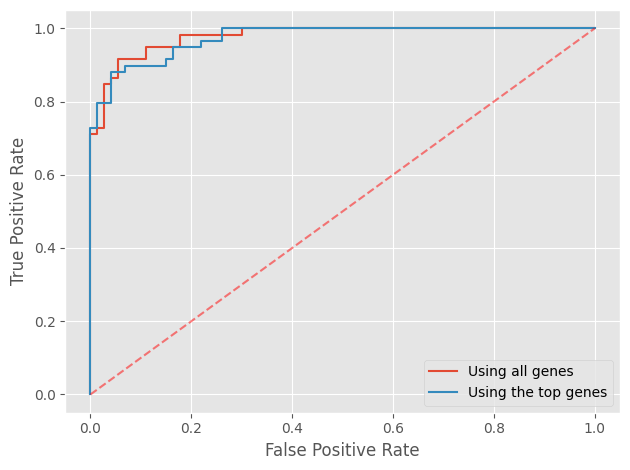

In [25]:
fig, ax = plt.subplots()

# plot the ROC curve for the random forest
ax.plot(false_positive_rate_rf, true_positive_rate_rf, label = "Using all genes")

# plot the ROC curve for the decision tree
ax.plot(false_positive_rate_new_model, true_positive_rate_new_model, label = "Using the top genes")

# plot the ROC curve that a coinflip would have
ax.plot([0,1], [0,1], color = 'red', alpha = 0.5, linestyle = '--')

# set x and y labels 
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

# add the legend to the plot 
ax.legend()

fig.tight_layout()

plt.show()

<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

## Summary and Next Time

In this notebook, you learned how to:
* evaluate a machine learning classification model 
* use SHAP to select the most important features
* identify a "panel" of biomarkers  
  
In this task, you likely found that even with 100 biomarker genes, the model with all of the gene expression data still performed better. Does this mean that we shouldn't use the biomarkers? Or that it isn't a useful panel? What can we conclude from this?


<div style="border: 2px solid #ddd; background-color: #f9f9f9; padding: 15px; margin: 10px 0; border-radius: 8px; color: #333;">

In the next session, a course instructor will look through your work and offer feedback.  
  
We will next look at survival analysis: the task of quantifying the increased risk associated with different subtypes. This is critical for translational work. We'd like to know what the clinical implications of our subtypes are, so we need to identify how they impact on survival for patients.